In [16]:
# import requests
# from datetime import datetime, date
# from classtoimport.Settings import Settings
# from classtoimport.RapidApi import RapidApi

# BOT_TOKEN = Settings().get({"section":"telegram","parameter":"bot_token"})
# CHAT_ID = Settings().get({"section":"telegram","parameter":"chat_id"})


# def telegramAlert():

#     sendMessage("🟡 Sem jogos pra hoje!")

# telegramAlert()

In [17]:
# If you have a GPU it can be used to improve performance.

# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [18]:

# lstm_model = LSTM_model(embedding_matrix,vocab_len,emb_dim)
# history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

# cnn_model= CNN_model(embedding_matrix,vocab_len)
# history = cnn_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),batch_size = batch_size, epochs = epochs)

# gru_model = GRU_model(embedding_matrix,vocab_len)
# history = gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)
                        
# cnn_gru_model = CNN_GRU_model(embedding_matrix,vocab_len)
# history = cnn_gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

# cnn_lstm_model = CNN_LSTM_model(embedding_matrix,vocab_len)
# history = cnn_lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

# lstmbd_model = BID_LSTM_model(embedding_matrix,vocab_len,emb_dim)
# history = lstmbd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

# grubd_model = BID_GRU_model(embedding_matrix,vocab_len,emb_dim)
# history = grubd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [19]:
import pandas as pd
import pickle

# REMOVED
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from src.preprocess import *
from src.models import *
from src.lib import *
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guilherme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Explore data

### kinds of cause:
- 1 = No reason
- 2 = Bias or abuse
- 3 = Jobs and careers
- 4 = Medication
- 5 = Relationships
- 6 = Alienation

In [20]:
import numpy as np
import pandas as pd

## Import training and Testing files
read_file_training = pd.read_csv('./data/added_CAMS_data.csv', encoding="ISO-8859-1")
read_file_testing = pd.read_csv('./data/IntentSDCNL_Testing.csv', encoding = "ISO-8859-1")


#training data
df_train = pd.DataFrame(read_file_training,columns= ['selftext','cause', 'inference']) # load data df_train
df_train = df_train.rename(columns={'selftext': 'text'}) # Rename columns:
df_train = df_train.convert_dtypes() # Convert columns to the best possible


#testing data
df_test = pd.DataFrame(read_file_testing,columns= ['selftext','ANNOTATIONS', 'Interpretations']) # load data df_test
df_test = df_test.rename(columns={'selftext': 'text', 'ANNOTATIONS': 'cause', 'Interpretations': 'inference'}) # Rename columns
df_test = df_test.convert_dtypes() # Convert columns to the best possible

# frame = [df_train]
# df_train =  pd.concat(frame)


In [21]:
# Removing some rows acoording rules below:
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.cause==" "].index, inplace=True)
df_test.drop(df_test[df_test.inference==" "].index, inplace=True)


# Removing some rows acoording rules below:
df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.cause==" "].index, inplace=True)
df_train.drop(df_train[df_train.inference==" "].index, inplace=True)

# Removing all nulls from both datasets.
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)




###### Class distribution of training data #####


<Axes: ylabel='count'>

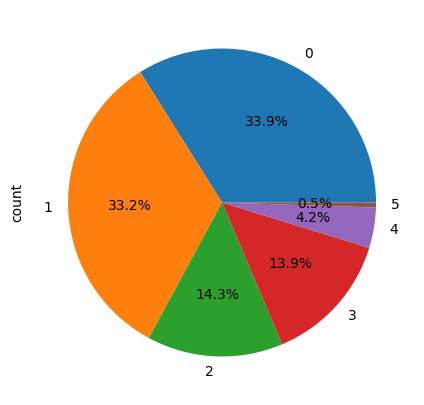

In [22]:

print("###### Class distribution of training data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_train['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

###### Class distribution of testing data #####


<Axes: ylabel='count'>

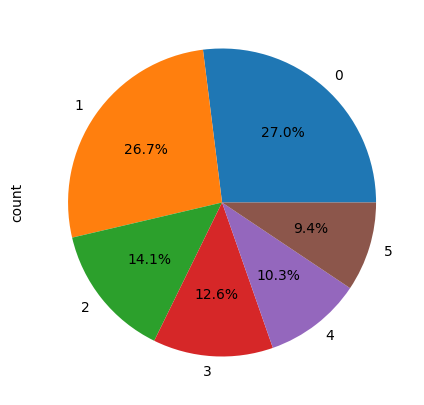

In [23]:

print("###### Class distribution of testing data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_test['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

In [24]:
frame = [df_test, df_train]
data =  pd.concat(frame)
data

,text,cause,inference
0,"Indubitably, I am not worth anything as a bein...",1,"not productive, worthless, hate, bored , issue..."
1,"Almost everyday I wake up hating myself, why w...",5,"feeling trapped, paranoid, barely talks to me,..."
2,To kill myself if im ugly?,1,ugly
3,God help me.... I know I should go to the hosp...,1,"abuse suffered, hard person to love, scars, cy..."
4,I really don't want to do anything anymore. Wh...,2,"wasting money, sulking, failure, disappointmen..."
...,...,...,...
3148,I'm sitting here just reading all your guy's a...,4,"living with grandmother to care, lost two aunt..."
3149,"Recently,I have developed a extremely annoying...",3,"cant get words out of mouth, social anxiety, m..."
3150,My depression has taken everything. I'm nearly...,5,"suffering from depression for 10 years, lost g..."
3151,"Hey guys, I'm a 22 year old male from Australi...",3,borderline personality disorder


#### A Sample

In [25]:
# print_plot(df_train,0)

## Clean and preprocess the text

####  Clean Training and Testing data

In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


#training data
df_train = df_train.reset_index(drop=True)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].str.replace('\d+', '')

##testing data
df_train = df_train.reset_index(drop=True)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')

#### A sample after cleanup

In [27]:
print_plot(df_train,0)
len(df_train)

look like drug addict lost much weight cant hold much food without throwing literally look anoreic eye bags bad theyre dark deep stop effects mom sees dont want know im depressed told look horrible dont like tell people depression either knowing people theyll make feel like depression isnt bad look like drug addict everyone need stop
text: 3


2877

#### Intialize parameters

In [28]:
# Define some Global Variables
max_nb_words = 60000
max_features = 10543 # Maximum Number of words we want to include in our dictionary
maxlen = 500 # No of words in question we want to create a sequence with
emb_dim = 100 # Size of word to vec embedding we are usingtokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

#### Initial Tokenizer

In [29]:
# tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)# tokenizer on whole training and testing data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18102 unique tokens.


In [30]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train, maxlen=maxlen)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (2877, 500)


In [31]:
Y_train = pd.get_dummies(df_train['cause']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (2877, 6)


In [32]:
X_test = tokenizer.texts_to_sequences(df_test['text'].values)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (341, 500)


In [33]:
Y_test = pd.get_dummies(df_test['cause']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (341, 6)


### Finally some validation data from Training Data

In [34]:
# Split arrays or matrices into random train and test subsets.
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,random_state=0,test_size=0.1)

In [35]:
print('TrainingData',X_train.shape,Y_train.shape)
print('TestingData',X_test.shape,Y_test.shape)
print('ValidationData',X_val.shape,Y_val.shape)


TrainingData (2589, 500) (2589, 6)
TestingData (341, 500) (341, 6)
ValidationData (288, 500) (288, 6)


In [36]:
#print a test sample
#print('test example:', X_test[100])
#len(X_test[100])

#### Intialize Embedding

In [37]:
embedding_vectors = {}

with open(f'./embeddings/glove.6B.{emb_dim}d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
        
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")


Size of vocabulary in GloVe: 400000


In [38]:
#initialize the embedding_matrix with zeros

if max_nb_words is not None: 
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1
    
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []

for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
            
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {len(oov_words)}')
print(f'A few out of valubulary words: {oov_words[0:10]}')

A few out of valubulary words: 4066
A few out of valubulary words: ["i'm", "don't", "i've", "it's", '\n\ni', "can't", 'iâ\x80\x99m', "didn't", 'donâ\x80\x99t', "doesn't"]


In [39]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

4066 out of 60000 words were OOV.


## NN models

In [40]:
##Global variables
batch_size = 256
epochs  = 20

#### a) LSTM Model

In [41]:
lstm_model = LSTM_model(embedding_matrix,vocab_len,emb_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         6000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 6,118,022
Trainable params: 118,022
Non-trainable params: 6,000,000
_________________________________________________________________
None


2023-08-18 22:34:52.156553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 22:34:52.159288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 22:34:52.162203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

##### Train the model

In [42]:
%%time
history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

Epoch 1/20


2023-08-18 22:34:56.102787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 22:34:56.105431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 22:34:56.107346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.5846 - accuracy: 0.3156

2023-08-18 22:35:25.069703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 22:35:25.072082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 22:35:25.075080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 31s 2s/step - loss: 1.5846 - accuracy: 0.3156 - val_loss: 1.4491 - val_accuracy: 0.3889
Epoch 2/20
11/11 [==============================] - 20s 2s/step - loss: 1.4753 - accuracy: 0.3453 - val_loss: 1.4219 - val_accuracy: 0.3750
Epoch 3/20
11/11 [==============================] - 20s 2s/step - loss: 1.4612 - accuracy: 0.3503 - val_loss: 1.4170 - val_accuracy: 0.3715
Epoch 4/20
11/11 [==============================] - 21s 2s/step - loss: 1.4427 - accuracy: 0.3735 - val_loss: 1.4134 - val_accuracy: 0.3958
Epoch 5/20
11/11 [==============================] - 21s 2s/step - loss: 1.4332 - accuracy: 0.3743 - val_loss: 1.4017 - val_accuracy: 0.3785
Epoch 6/20
11/11 [==============================] - 20s 2s/step - loss: 1.4144 - accuracy: 0.3936 - val_loss: 1.3955 - val_accuracy: 0.3993
Epoch 7/20
11/11 [==============================] - 20s 2s/step - loss: 1.3874 - accuracy: 0.4210 - val_loss: 1.3956 - val_accuracy: 0.4340
Epoch 8/20
11/11 [=============

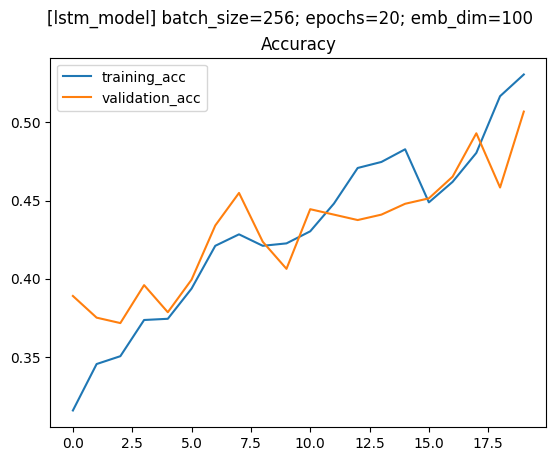

In [43]:
#plot accuracy

plot_accuracy(history,epochs,f"[lstm_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [44]:
# Accuracy
train_test_accuracy(lstm_model,X_train,Y_train,X_test,Y_test)


Train accuracy: 50.25
Test accuracy: 45.16


In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

In [51]:
### kinds of cause:
# - 1 = No reason
# - 2 = Bias or abuse
# - 3 = Jobs and careers
# - 4 = Medication
# - 5 = Relationships
# - 6 = Alienation

read_file_predict = pd.read_csv('./data/tweets_to_predict_test.csv', encoding = "ISO-8859-1")

# predict data  | fields = "target","ids","date","flag","user","text"
df_predict = pd.DataFrame(read_file_predict,columns= ['target','text'])
df_predict = df_predict.convert_dtypes() # Convert columns to the best possible
df_predict.dropna(inplace=True)
df_predict = df_predict[df_predict.target == 0]

##predict data
df_predict = df_predict.reset_index(drop=True)
df_predict['text'] = df_predict['text'].apply(clean_text)
df_predict['text'] = df_predict['text'].str.replace('\d+', '')


X_predict = tokenizer.texts_to_sequences(df_predict['text'][:1].values)
X_predict = pad_sequences(X_predict, maxlen=maxlen)
pred = lstm_model.predict(X_predict)
labels = ["0", "1", "2", "3", "4", "5"]
print("Text:", df_predict['text'][:1].values)
print(pred, labels[np.argmax(pred)])
print('\n\n')
print("prediction shape:", pred.shape)
print("prediction:", pred)

1/1 [==============================] - 0s 109ms/step
Text: ['switchfoot http twitpiccom 2y1zl awww thats bummer shoulda got david carr third day']
[[0.19751681 0.2579868  0.37857354 0.618169   0.61942196 0.8571506 ]] 5



prediction shape: (1, 6)
prediction: [[0.19751681 0.2579868  0.37857354 0.618169   0.61942196 0.8571506 ]]


In [ ]:
# np.asarray([float(val) for val in values[1:]])
# tt_predict = np.array(tt_predict)
model_pr = lstm_model.predict(X_predict[:10],verbose=1)
print(f"prediction: {model_pr.shape}") 

In [ ]:
#Classification report
report_nn(lstm_model,X_test,Y_test)

#### b) CNN

In [ ]:
cnn_model=CNN_model(embedding_matrix,vocab_len)

##### Train the model

In [ ]:
%%time
history = cnn_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),batch_size = batch_size, epochs = epochs)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs,f"[cnn_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(cnn_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_model,X_test,Y_test)

#### d) GRU

In [ ]:
gru_model = GRU_model(embedding_matrix,vocab_len)

In [ ]:
%%time
history = gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs,f"[gru_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(gru_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(gru_model,X_test,Y_test)


#### e) CNN+GRU

In [ ]:
cnn_gru_model = CNN_GRU_model(embedding_matrix,vocab_len)

In [ ]:
%%time
history=cnn_gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs,f"[cnn_gru_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(cnn_gru_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_gru_model,X_test,Y_test)

#### f) CNN+LSTM

In [ ]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix,vocab_len)

In [ ]:
%%time
history=cnn_lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history, epochs,f"[cnn_lstm_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

##### Confusion Matrix

In [ ]:
#cnn_lstm_model0=cnn_lstm_model
print('--Confusion Matrix for CNN+LSTM--')
print_confusion(cnn_lstm_model,X_test,Y_test)

#### Bidirectional LSTM models

In [ ]:
lstmbd_model = BID_LSTM_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
%%time
history=lstmbd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs,f"[lstmbd_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(lstmbd_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(lstmbd_model,X_test,Y_test)

#### Bidirectional GRU

In [ ]:
grubd_model = BID_GRU_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
%%time
history=grubd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs,f"[grubd_model] batch_size={batch_size}; epochs={epochs}; emb_dim={emb_dim}")

In [ ]:
# Accuracy
train_test_accuracy(grubd_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(grubd_model,X_test,Y_test)